In [71]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import pickle 
from ply import write_ply

from utilities import *
from VoxelGrid import *
import os

from PIL import ImageFont
from PIL import ImageDraw 

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device='cuda' if torch.cuda.is_available() else 'cpu'

N_points=200
dataset= "../nerf_synthetic/chair"

In [72]:
focal, all_c2w, all_gt = get_data(dataset)

LOAD DATA ../nerf_synthetic/chair/train


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 55.58it/s]


In [74]:
red = 8
target_ims, rays = reduce_data(all_c2w, all_gt, focal, red)
im_w = target_ims[0].shape[0]
print(im_w)

red = 2
disp_ims, disp_rays = reduce_data(all_c2w, all_gt, focal, red)
disp_im_w = disp_ims[0].shape[0]
print(disp_im_w)

100
400


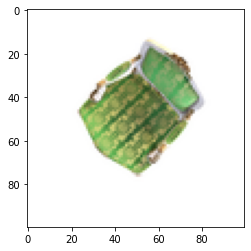

In [75]:
plt.imshow(target_ims[1])
plt.show()

In [ ]:
test_focal, test_c2w, test_gt = get_data(dataset, "test")

In [31]:
red = 4
disp_ims_test, disp_rays_test = reduce_data(test_c2w, test_gt,test_focal, red)
disp_im_w = disp_ims_test[0].shape[0]

# Train

In [76]:
D = RayDataset(target_ims, rays, device)
train_loader = torch.utils.data.DataLoader(D, batch_size=5000, shuffle=True)

100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.46it/s]


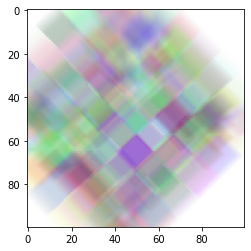

In [121]:
VG = VoxelGrid(8, 1.2)
plt.imshow(VG.render_large_image_from_rays(rays[1],(1000, 1.2)))

In [122]:
losses=[]

In [123]:
def train(epoch, optimizer_op, optimizer_col, N_points):
    losses=[]
    for batch_idx, (rays, pixels) in enumerate(train_loader):
        rays, pixels = (rays[0].to(device),rays[1].to(device)), pixels.to(device)
        optimizer_op.zero_grad()
        optimizer_col.zero_grad()
        
        pix_estims = VG.render_rays(rays, (N_points))
        
        loss = ((pix_estims-pixels)**2).sum()/rays[0].shape[0] +0.0001*VG.total_variation()
        #loss = ((pix_estims-pixels)**2).sum()/rays[0].shape[0]
        loss.backward()
        losses.append(loss.item())
        #VG.update_grads(1000)
        optimizer_op.step()
        optimizer_col.step()
        VG.clamp()
        if batch_idx%10==0:
            print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        epoch,
                        batch_idx,
                        len(train_loader),
                        100.0 * batch_idx / len(train_loader),
                        loss.data.item(),
                    )
                )
    return losses

  0%|                                                     | 0/2 [00:00<?, ?it/s]

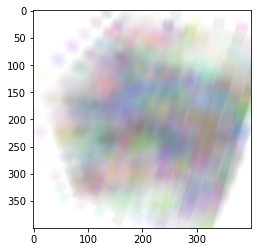

Train Epoch: 0 [0/200 (0%)]	Loss: 0.152439
Train Epoch: 0 [10/200 (5%)]	Loss: 0.087900
Train Epoch: 0 [20/200 (10%)]	Loss: 0.047356
Train Epoch: 0 [30/200 (15%)]	Loss: 0.040054
Train Epoch: 0 [40/200 (20%)]	Loss: 0.039386
Train Epoch: 0 [50/200 (25%)]	Loss: 0.039460
Train Epoch: 0 [60/200 (30%)]	Loss: 0.042457
Train Epoch: 0 [70/200 (35%)]	Loss: 0.038963
Train Epoch: 0 [80/200 (40%)]	Loss: 0.041108
Train Epoch: 0 [90/200 (45%)]	Loss: 0.039871
Train Epoch: 0 [100/200 (50%)]	Loss: 0.039390
Train Epoch: 0 [110/200 (55%)]	Loss: 0.038020
Train Epoch: 0 [120/200 (60%)]	Loss: 0.038710
Train Epoch: 0 [130/200 (65%)]	Loss: 0.034389
Train Epoch: 0 [140/200 (70%)]	Loss: 0.036521
Train Epoch: 0 [150/200 (75%)]	Loss: 0.032387
Train Epoch: 0 [160/200 (80%)]	Loss: 0.033811
Train Epoch: 0 [170/200 (85%)]	Loss: 0.034562
Train Epoch: 0 [180/200 (90%)]	Loss: 0.031105
Train Epoch: 0 [190/200 (95%)]	Loss: 0.031596


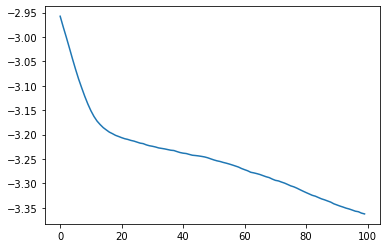

 50%|██████████████████████▌                      | 1/2 [00:37<00:37, 37.13s/it]

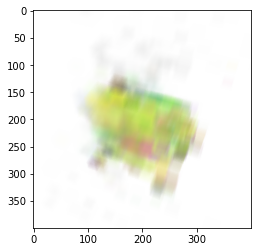

Train Epoch: 1 [0/200 (0%)]	Loss: 0.031874
Train Epoch: 1 [10/200 (5%)]	Loss: 0.034282
Train Epoch: 1 [20/200 (10%)]	Loss: 0.034407
Train Epoch: 1 [30/200 (15%)]	Loss: 0.030172
Train Epoch: 1 [40/200 (20%)]	Loss: 0.029755
Train Epoch: 1 [50/200 (25%)]	Loss: 0.031917
Train Epoch: 1 [60/200 (30%)]	Loss: 0.030169
Train Epoch: 1 [70/200 (35%)]	Loss: 0.030762
Train Epoch: 1 [80/200 (40%)]	Loss: 0.032352
Train Epoch: 1 [90/200 (45%)]	Loss: 0.030237
Train Epoch: 1 [100/200 (50%)]	Loss: 0.029947
Train Epoch: 1 [110/200 (55%)]	Loss: 0.030733
Train Epoch: 1 [120/200 (60%)]	Loss: 0.029882
Train Epoch: 1 [130/200 (65%)]	Loss: 0.031046
Train Epoch: 1 [140/200 (70%)]	Loss: 0.030941
Train Epoch: 1 [150/200 (75%)]	Loss: 0.029108
Train Epoch: 1 [160/200 (80%)]	Loss: 0.030487
Train Epoch: 1 [170/200 (85%)]	Loss: 0.029658
Train Epoch: 1 [180/200 (90%)]	Loss: 0.028757
Train Epoch: 1 [190/200 (95%)]	Loss: 0.028115


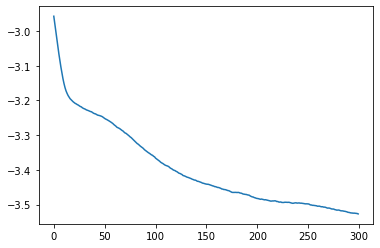

  0%|                                                     | 0/4 [00:00<?, ?it/s]

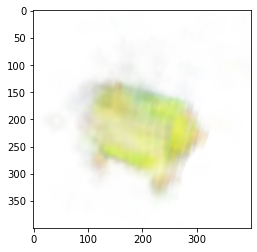

Train Epoch: 0 [0/200 (0%)]	Loss: 0.031336
Train Epoch: 0 [10/200 (5%)]	Loss: 0.031412
Train Epoch: 0 [20/200 (10%)]	Loss: 0.030828
Train Epoch: 0 [30/200 (15%)]	Loss: 0.029653
Train Epoch: 0 [40/200 (20%)]	Loss: 0.029169
Train Epoch: 0 [50/200 (25%)]	Loss: 0.029161
Train Epoch: 0 [60/200 (30%)]	Loss: 0.028371
Train Epoch: 0 [70/200 (35%)]	Loss: 0.029040
Train Epoch: 0 [80/200 (40%)]	Loss: 0.027242
Train Epoch: 0 [90/200 (45%)]	Loss: 0.026906
Train Epoch: 0 [100/200 (50%)]	Loss: 0.025919
Train Epoch: 0 [110/200 (55%)]	Loss: 0.024799
Train Epoch: 0 [120/200 (60%)]	Loss: 0.025699
Train Epoch: 0 [130/200 (65%)]	Loss: 0.022234
Train Epoch: 0 [140/200 (70%)]	Loss: 0.023843
Train Epoch: 0 [150/200 (75%)]	Loss: 0.020638
Train Epoch: 0 [160/200 (80%)]	Loss: 0.021018
Train Epoch: 0 [170/200 (85%)]	Loss: 0.023082
Train Epoch: 0 [180/200 (90%)]	Loss: 0.021075
Train Epoch: 0 [190/200 (95%)]	Loss: 0.021686


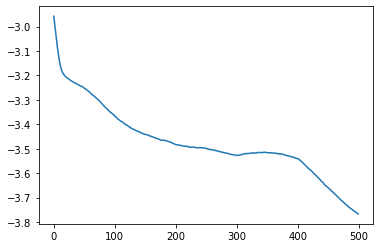

 25%|███████████▎                                 | 1/4 [01:08<03:24, 68.07s/it]

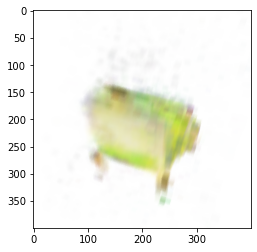

Train Epoch: 1 [0/200 (0%)]	Loss: 0.020177
Train Epoch: 1 [10/200 (5%)]	Loss: 0.018962
Train Epoch: 1 [20/200 (10%)]	Loss: 0.021396
Train Epoch: 1 [30/200 (15%)]	Loss: 0.022897
Train Epoch: 1 [40/200 (20%)]	Loss: 0.021198
Train Epoch: 1 [50/200 (25%)]	Loss: 0.020546
Train Epoch: 1 [60/200 (30%)]	Loss: 0.021110
Train Epoch: 1 [70/200 (35%)]	Loss: 0.021336
Train Epoch: 1 [80/200 (40%)]	Loss: 0.021566
Train Epoch: 1 [90/200 (45%)]	Loss: 0.022556
Train Epoch: 1 [100/200 (50%)]	Loss: 0.022154
Train Epoch: 1 [110/200 (55%)]	Loss: 0.020826
Train Epoch: 1 [120/200 (60%)]	Loss: 0.021599
Train Epoch: 1 [130/200 (65%)]	Loss: 0.020728
Train Epoch: 1 [140/200 (70%)]	Loss: 0.019749
Train Epoch: 1 [150/200 (75%)]	Loss: 0.020949
Train Epoch: 1 [160/200 (80%)]	Loss: 0.022219
Train Epoch: 1 [170/200 (85%)]	Loss: 0.021113
Train Epoch: 1 [180/200 (90%)]	Loss: 0.021888
Train Epoch: 1 [190/200 (95%)]	Loss: 0.022048


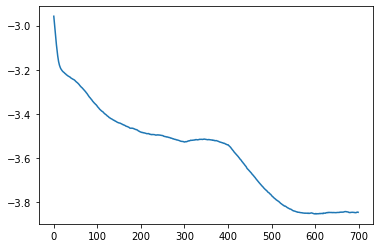

 50%|██████████████████████▌                      | 2/4 [02:15<02:15, 67.63s/it]

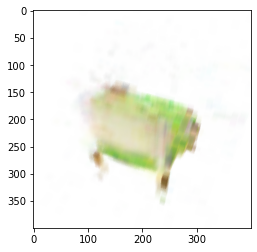

Train Epoch: 2 [0/200 (0%)]	Loss: 0.022547
Train Epoch: 2 [10/200 (5%)]	Loss: 0.020888
Train Epoch: 2 [20/200 (10%)]	Loss: 0.020202
Train Epoch: 2 [30/200 (15%)]	Loss: 0.020793
Train Epoch: 2 [40/200 (20%)]	Loss: 0.020312
Train Epoch: 2 [50/200 (25%)]	Loss: 0.019547
Train Epoch: 2 [60/200 (30%)]	Loss: 0.020481
Train Epoch: 2 [70/200 (35%)]	Loss: 0.019709
Train Epoch: 2 [80/200 (40%)]	Loss: 0.020229
Train Epoch: 2 [90/200 (45%)]	Loss: 0.019394
Train Epoch: 2 [100/200 (50%)]	Loss: 0.019869
Train Epoch: 2 [110/200 (55%)]	Loss: 0.019100
Train Epoch: 2 [120/200 (60%)]	Loss: 0.019822
Train Epoch: 2 [130/200 (65%)]	Loss: 0.019639
Train Epoch: 2 [140/200 (70%)]	Loss: 0.020560
Train Epoch: 2 [150/200 (75%)]	Loss: 0.020663
Train Epoch: 2 [160/200 (80%)]	Loss: 0.019767
Train Epoch: 2 [170/200 (85%)]	Loss: 0.019172
Train Epoch: 2 [180/200 (90%)]	Loss: 0.019272
Train Epoch: 2 [190/200 (95%)]	Loss: 0.018986


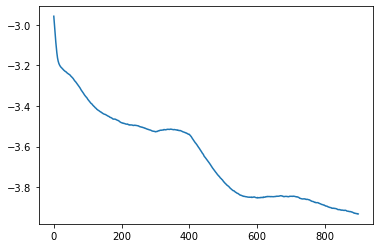

 75%|█████████████████████████████████▊           | 3/4 [03:23<01:08, 68.07s/it]

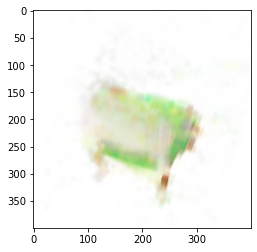

Train Epoch: 3 [0/200 (0%)]	Loss: 0.019386
Train Epoch: 3 [10/200 (5%)]	Loss: 0.018494
Train Epoch: 3 [20/200 (10%)]	Loss: 0.018135
Train Epoch: 3 [30/200 (15%)]	Loss: 0.020612
Train Epoch: 3 [40/200 (20%)]	Loss: 0.018159
Train Epoch: 3 [50/200 (25%)]	Loss: 0.019203
Train Epoch: 3 [60/200 (30%)]	Loss: 0.018561
Train Epoch: 3 [70/200 (35%)]	Loss: 0.019027
Train Epoch: 3 [80/200 (40%)]	Loss: 0.019639
Train Epoch: 3 [90/200 (45%)]	Loss: 0.018420
Train Epoch: 3 [100/200 (50%)]	Loss: 0.019659
Train Epoch: 3 [110/200 (55%)]	Loss: 0.020271
Train Epoch: 3 [120/200 (60%)]	Loss: 0.018892
Train Epoch: 3 [130/200 (65%)]	Loss: 0.019752
Train Epoch: 3 [140/200 (70%)]	Loss: 0.020046
Train Epoch: 3 [150/200 (75%)]	Loss: 0.018981
Train Epoch: 3 [160/200 (80%)]	Loss: 0.018086
Train Epoch: 3 [170/200 (85%)]	Loss: 0.019192
Train Epoch: 3 [180/200 (90%)]	Loss: 0.018856
Train Epoch: 3 [190/200 (95%)]	Loss: 0.019672


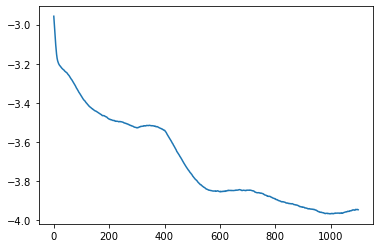

  0%|                                                     | 0/8 [00:00<?, ?it/s]

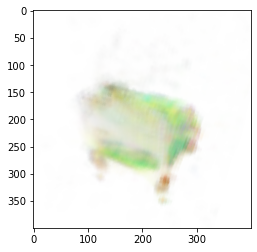

Train Epoch: 0 [0/200 (0%)]	Loss: 0.024728
Train Epoch: 0 [10/200 (5%)]	Loss: 0.024924
Train Epoch: 0 [20/200 (10%)]	Loss: 0.023881
Train Epoch: 0 [30/200 (15%)]	Loss: 0.021414
Train Epoch: 0 [40/200 (20%)]	Loss: 0.022551
Train Epoch: 0 [50/200 (25%)]	Loss: 0.021929
Train Epoch: 0 [60/200 (30%)]	Loss: 0.023595


  0%|                                                     | 0/8 [00:49<?, ?it/s]


KeyboardInterrupt: 

In [124]:
epochss = [2,4,8, 8]
N_pointss = [50, 100, 200, 200]
lrs = [30, 30, 30, 30]
lrs2 = [0.3, 0.3, 0.3, 0.3]



for epochs, N_points, lr, lr2 in zip(epochss,N_pointss, lrs,lrs2):
    VG.subdivide()
    opt1 = torch.optim.SGD(
                [VG.opacities], 
                lr=lr
            )
    opt2 = torch.optim.SGD(
                [VG.colors], 
                lr=lr2
            )


    for epoch in tqdm(range(epochs)):
        new_im = VG.render_large_image_from_rays(disp_rays[0],(500,1.2))
        plt.imshow(new_im)
        plt.show()

        #VG.save("some.obj")
        losses += train(epoch, opt1,opt2, N_points)
        plt.plot(np.log(rolling_average(np.array(losses))))
        plt.show()


    

In [101]:


loss_tab = np.log(rolling_average(np.array(losses2), 10))
plt.plot(loss_tab, label='Adaptative grid size (16 to 128)')


x = np.array([200*2-10, 200*6, 200*14])
y = loss_tab[x.astype(int)]

plt.plot(x,y,'o', label='subdivisions')



loss_tab = rolling_average(np.array(losses), 10)
plt.plot(np.log(loss_tab), label='Fixed grid size (128)')

plt.ylabel("Error")
plt.xlabel("Iterations")
plt.legend()
#plt.savefig('exports/training.png')

NameError: name 'losses2' is not defined

# View images

In [8]:
VG = VoxelGrid()

model = "drums"
VG.load(model+'.obj')



In [9]:
dataset= "../nerf_synthetic/"+model
test_focal, test_c2w, test_gt = get_data(dataset, "test")
red = 4
disp_ims_test, disp_rays_test = reduce_data(test_c2w, test_gt,test_focal, red)


LOAD DATA ../nerf_synthetic/drums/test


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 47.31it/s]


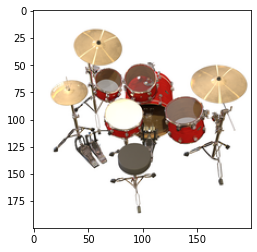

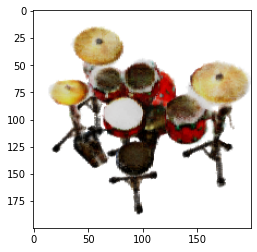

In [19]:
image_ind=0


plt.imshow(disp_ims_test[image_ind])
plt.show()

new_im = VG.render_large_image_from_rays(disp_rays_test[image_ind],(1000,1.2))

plt.imshow(new_im)
plt.show()

# ROTATION

In [36]:
cust_c2ws = create_rotation_matrices(1.5,-20, n=60)
red_fac=4
ordir_rays=[]
for c2w in cust_c2ws:
    ray_np = get_rays_np(800,800, focal, c2w)
    oris = ray_np[0][::red_fac,::red_fac]
    direct = ray_np[1][::red_fac,::red_fac] # direction. optimal fac:3
    ordir_rays.append((oris, direct))

In [33]:
VG=VoxelGrid()
VG.load('out_grid.obj')

  0%|                                                    | 0/60 [00:00<?, ?it/s]

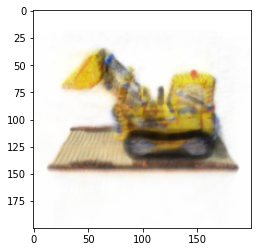

  2%|▋                                           | 1/60 [00:00<00:14,  4.12it/s]

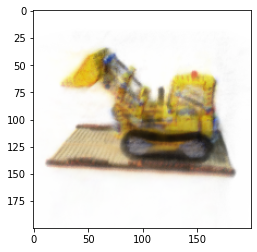

  3%|█▍                                          | 2/60 [00:00<00:13,  4.22it/s]

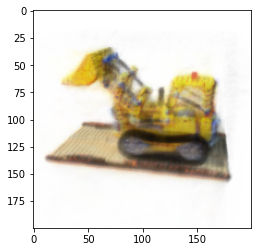

  5%|██▏                                         | 3/60 [00:00<00:13,  4.26it/s]

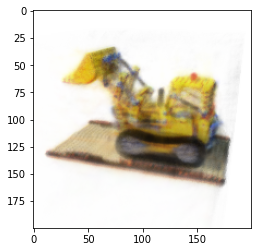

  7%|██▉                                         | 4/60 [00:00<00:12,  4.34it/s]

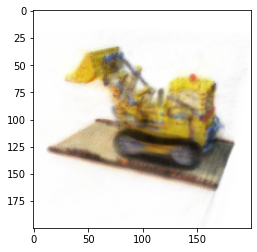

  8%|███▋                                        | 5/60 [00:01<00:12,  4.40it/s]

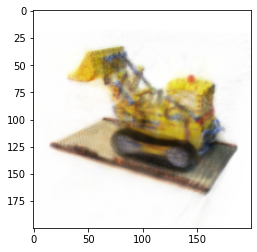

 10%|████▍                                       | 6/60 [00:01<00:12,  4.43it/s]

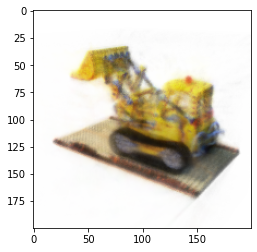

 12%|█████▏                                      | 7/60 [00:01<00:11,  4.48it/s]

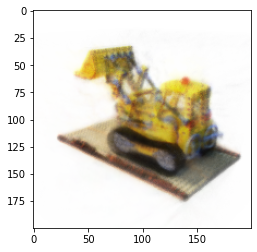

 13%|█████▊                                      | 8/60 [00:01<00:11,  4.52it/s]

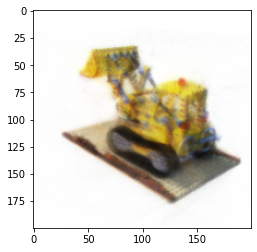

 15%|██████▌                                     | 9/60 [00:02<00:11,  4.55it/s]

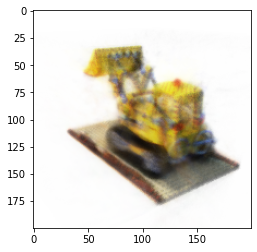

 17%|███████▏                                   | 10/60 [00:02<00:10,  4.59it/s]

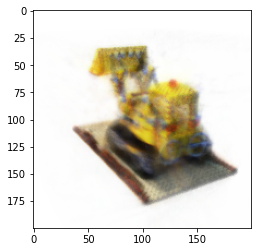

 18%|███████▉                                   | 11/60 [00:02<00:10,  4.62it/s]

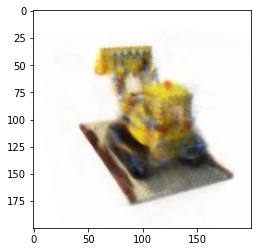

 20%|████████▌                                  | 12/60 [00:02<00:11,  4.36it/s]

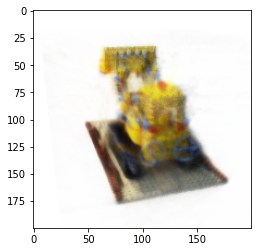

 22%|█████████▎                                 | 13/60 [00:02<00:10,  4.46it/s]

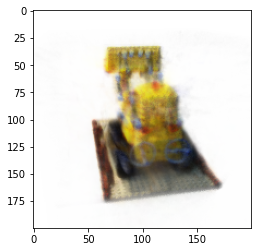

 23%|██████████                                 | 14/60 [00:03<00:10,  4.54it/s]

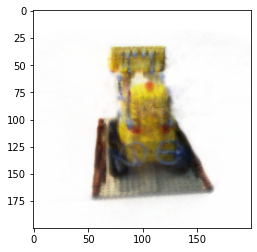

 25%|██████████▊                                | 15/60 [00:03<00:09,  4.59it/s]

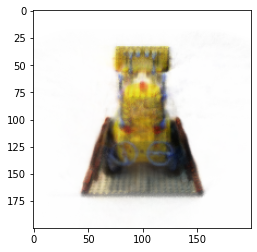

 27%|███████████▍                               | 16/60 [00:03<00:09,  4.64it/s]

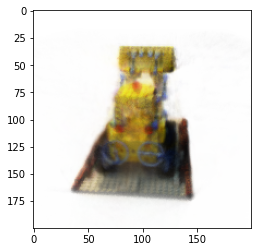

 28%|████████████▏                              | 17/60 [00:03<00:09,  4.67it/s]

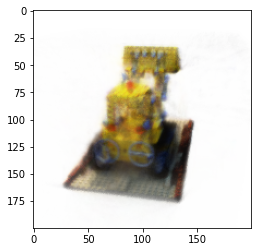

 30%|████████████▉                              | 18/60 [00:03<00:08,  4.69it/s]

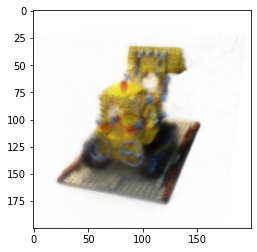

 32%|█████████████▌                             | 19/60 [00:04<00:08,  4.71it/s]

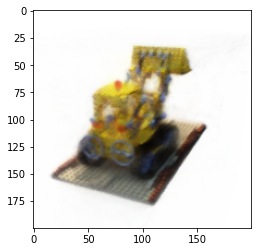

 33%|██████████████▎                            | 20/60 [00:04<00:08,  4.71it/s]

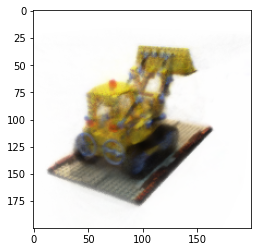

 35%|███████████████                            | 21/60 [00:04<00:08,  4.71it/s]

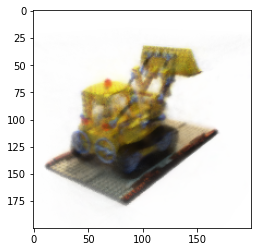

 37%|███████████████▊                           | 22/60 [00:04<00:08,  4.71it/s]

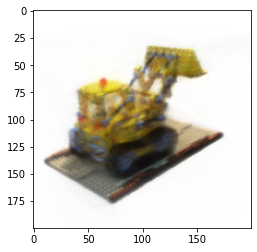

 38%|████████████████▍                          | 23/60 [00:05<00:07,  4.71it/s]

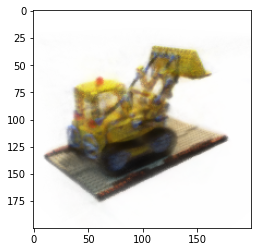

 40%|█████████████████▏                         | 24/60 [00:05<00:07,  4.71it/s]

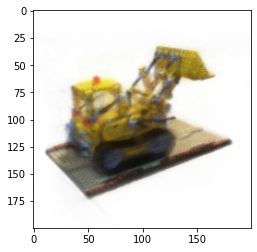

 42%|█████████████████▉                         | 25/60 [00:05<00:07,  4.69it/s]

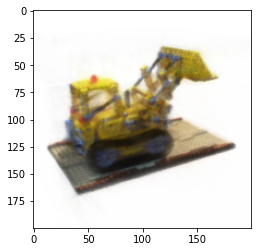

 43%|██████████████████▋                        | 26/60 [00:05<00:07,  4.68it/s]

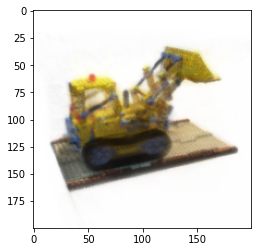

 45%|███████████████████▎                       | 27/60 [00:05<00:07,  4.68it/s]

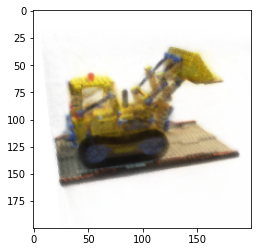

 47%|████████████████████                       | 28/60 [00:06<00:06,  4.68it/s]

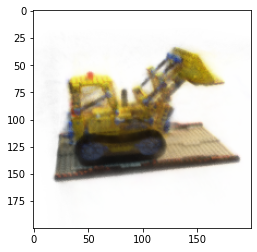

 48%|████████████████████▊                      | 29/60 [00:06<00:06,  4.68it/s]

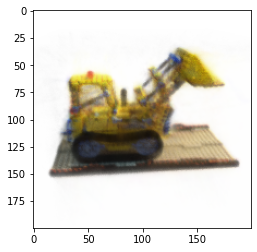

 50%|█████████████████████▌                     | 30/60 [00:06<00:06,  4.68it/s]

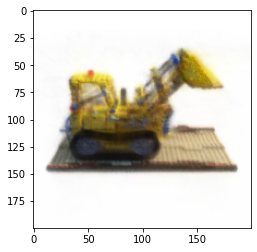

 52%|██████████████████████▏                    | 31/60 [00:06<00:06,  4.36it/s]

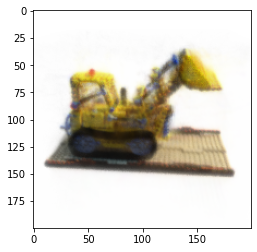

 53%|██████████████████████▉                    | 32/60 [00:07<00:06,  4.45it/s]

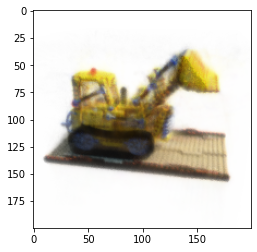

 55%|███████████████████████▋                   | 33/60 [00:07<00:05,  4.64it/s]

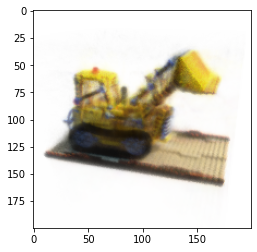

 57%|████████████████████████▎                  | 34/60 [00:07<00:05,  4.79it/s]

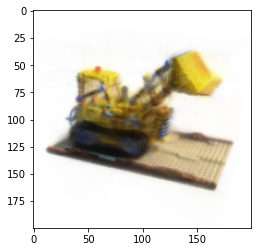

 58%|█████████████████████████                  | 35/60 [00:07<00:05,  4.90it/s]

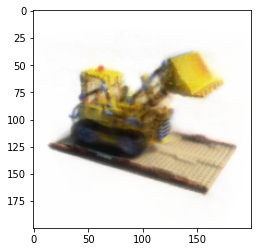

 60%|█████████████████████████▊                 | 36/60 [00:07<00:04,  4.98it/s]

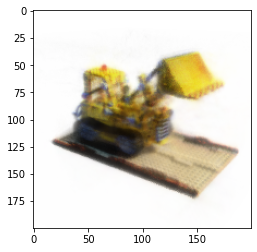

 62%|██████████████████████████▌                | 37/60 [00:07<00:04,  5.04it/s]

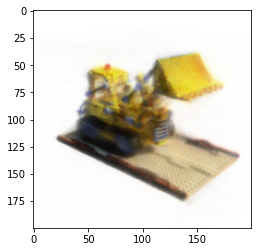

 63%|███████████████████████████▏               | 38/60 [00:08<00:04,  5.09it/s]

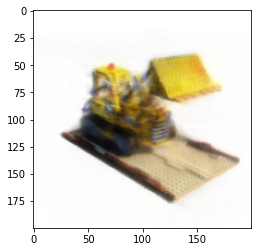

 65%|███████████████████████████▉               | 39/60 [00:08<00:04,  4.96it/s]

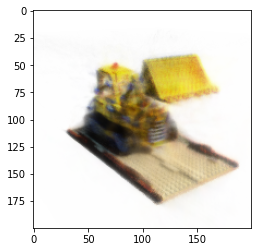

 67%|████████████████████████████▋              | 40/60 [00:08<00:03,  5.03it/s]

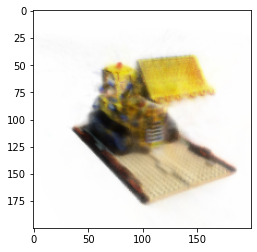

 68%|█████████████████████████████▍             | 41/60 [00:08<00:03,  5.08it/s]

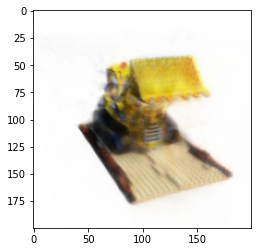

 70%|██████████████████████████████             | 42/60 [00:08<00:03,  5.13it/s]

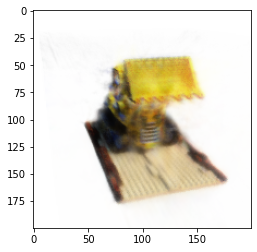

 72%|██████████████████████████████▊            | 43/60 [00:09<00:03,  5.17it/s]

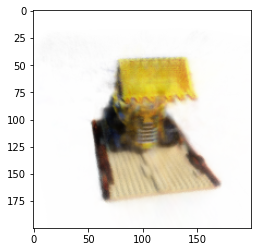

 73%|███████████████████████████████▌           | 44/60 [00:09<00:03,  5.05it/s]

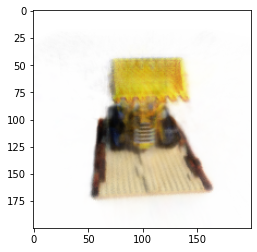

 75%|████████████████████████████████▎          | 45/60 [00:09<00:03,  4.93it/s]

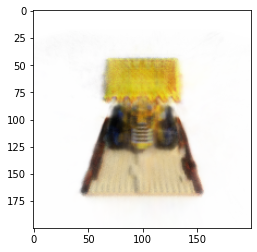

 77%|████████████████████████████████▉          | 46/60 [00:09<00:02,  4.88it/s]

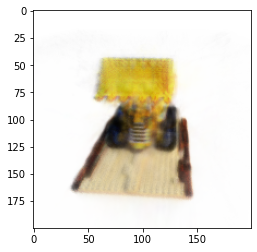

 78%|█████████████████████████████████▋         | 47/60 [00:09<00:02,  4.83it/s]

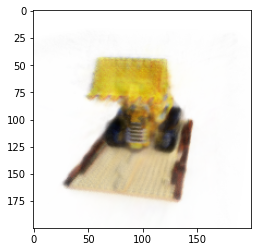

 80%|██████████████████████████████████▍        | 48/60 [00:10<00:02,  4.81it/s]

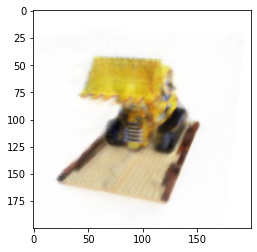

 82%|███████████████████████████████████        | 49/60 [00:10<00:02,  4.78it/s]

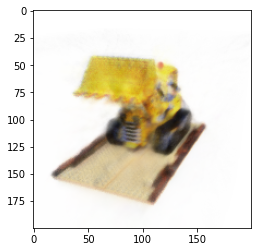

 83%|███████████████████████████████████▊       | 50/60 [00:10<00:02,  4.43it/s]

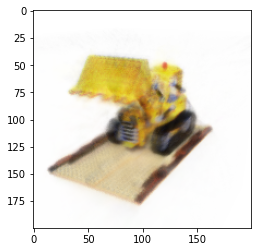

 85%|████████████████████████████████████▌      | 51/60 [00:10<00:01,  4.51it/s]

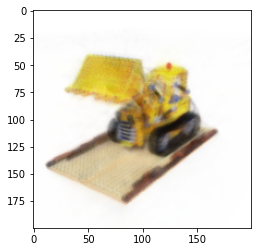

 87%|█████████████████████████████████████▎     | 52/60 [00:11<00:01,  4.62it/s]

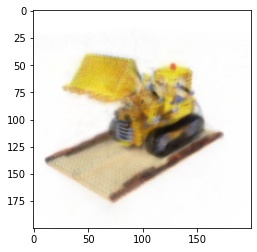

 88%|█████████████████████████████████████▉     | 53/60 [00:11<00:01,  4.78it/s]

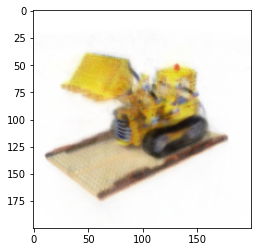

 90%|██████████████████████████████████████▋    | 54/60 [00:11<00:01,  4.88it/s]

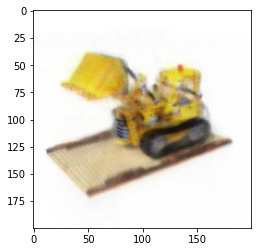

 92%|███████████████████████████████████████▍   | 55/60 [00:11<00:01,  4.96it/s]

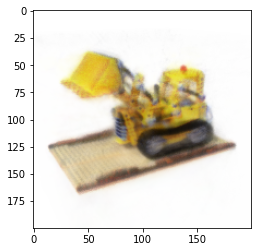

 93%|████████████████████████████████████████▏  | 56/60 [00:11<00:00,  5.01it/s]

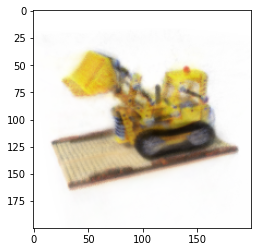

 95%|████████████████████████████████████████▊  | 57/60 [00:12<00:00,  5.04it/s]

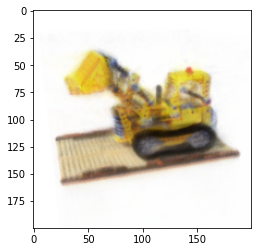

 97%|█████████████████████████████████████████▌ | 58/60 [00:12<00:00,  5.07it/s]

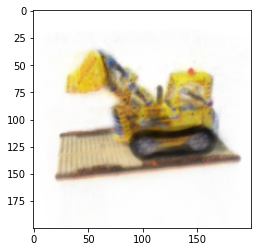

 98%|██████████████████████████████████████████▎| 59/60 [00:12<00:00,  5.08it/s]

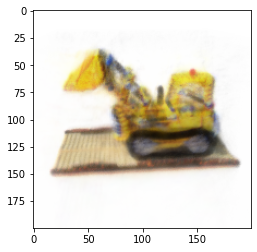

100%|███████████████████████████████████████████| 60/60 [00:12<00:00,  4.74it/s]


In [37]:
imgs=[]
for image_ind in tqdm(range(len(cust_c2ws))):
    with torch.no_grad():
        new_im = VG.render_large_image_from_rays(ordir_rays[image_ind],(500, 1.2))
        plt.imshow(new_im)
        plt.show()
        imgs.append(np.uint8(255*new_im))

In [38]:
imageio.mimwrite('screenshots/lego_best.gif', imgs,  format='GIF', duration=0.04)

In [144]:
VG.save_pointcloud()

In [11]:
rays_or_dir = [get_rays_np(800,800, focal, c2w) for c2w in all_c2w]

In [12]:
camera_centers = get_cameras_centers(rays_or_dir)

[3.8 0.  1. ]


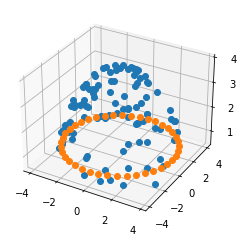

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot( camera_centers[:,0], camera_centers[:, 1], camera_centers[:,2], 'o')

n = 40
t = np.linspace(0,2*np.pi, n+1)[:-1]
cust_centers = np.zeros((n,3))
cust_centers[:,0] = np.cos(t)*3.8
cust_centers[:,1] = np.sin(t)*3.8
cust_centers[:,2] = 1

cust_c2ws = [create_rotation_transformation_matrix(cust_centers[i], t[i], -np.pi*0.1) for i in range(n)]

ax.plot( cust_centers[:,0], cust_centers[:,1], cust_centers[:,2], 'o')

print(cust_centers[0])



In [12]:
L=[]
k=0
i=0
while i<39:
    k+=1
    for _ in range(4):
        L.append(i)
        i+=k
L

[0, 1, 2, 3, 4, 6, 8, 10, 12, 15, 18, 21, 24, 28, 32, 36]

In [64]:
L = range(15)

In [8]:

images=[]
for ind in tqdm(range(34)):
    VG.load('16sph'+str(ind)+'.obj')
    for image_ind in (range(len(cust_c2ws))):
        new_im = VG.render_large_image_from_rays(ordir_rays[image_ind], (1000, 1.2))
        img = Image.fromarray(np.uint8(255*np.clip(new_im,0,1)))
        draw = ImageDraw.Draw(img)
        draw.text((10, 10),"Epoch:"+str(ind),(0,0,0))
        images.append(np.array(img))
        #plt.imshow(images[-1])
        #plt.show()
        #images.append(np.uint8(255*new_im))
        #plt.imsave('screenshots/rotate/'+str(ind)+'_'+str(image_ind)+'.png', new_im)


100%|███████████████████████████████████████████| 34/34 [16:56<00:00, 29.89s/it]


In [36]:
images2=[]
k=0
while k<len(images):
    for _ in range(30):
        images2.append(images[k])
        k+=1
    k+=60

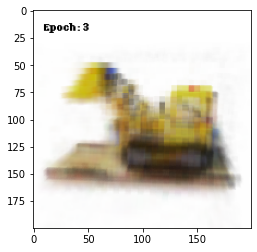

In [45]:
plt.imshow(images2[61])

In [30]:
imageio.mimwrite('screenshots/movies_drums2.gif', imgs,  format='GIF', duration=0.04)